# Segmentation of tissues in head and neck CT Scan

Segmentation of bone, fat, left arm muscle, right arm muscle, pectoral muscle and back muscle. Measures density, mass and volume of each. 

The CT scans should be in NRRD format and copied to 'images' folder in the file directory.
The density, mass and volume data will be put in a CSV file named 'data.csv' in the same directory.
The segmented images will be put into result folder. 

Written by Glenn Chang (glennkengmanchang@gmail.com)

In [1]:
import os as os
import sys
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from skimage.measure import label, regionprops
from skimage.segmentation import active_contour
from skimage.filters import threshold_otsu, threshold_multiotsu
import pydicom
import cv2 
from collections import Counter
import nrrd
from scipy import stats
import pandas as pd
from openpyxl import load_workbook


In [81]:
#Used for looping this jupyter notebook. 
try:
    name = file.pop() # Remove one file to segment every iteration
    name_split = name.split('.') 
except NameError: 
    # Error in first iteration to get filenames
    file_path = os.path.join('images')
    file = os.listdir(file_path)
    name = file.pop()
    name_split = name.split('.')
    while len(name_split) == 1 or name_split[1] != 'nrrd':
        name = file.pop()
        name_split = name.split('.')
except IndexError: 
    # Finish running all images
    df = pd.read_csv('data.csv')
    append_df_to_excel('statistics.xlsx', df) # Transfer from CSV to XLSX for statstics on Sheet2
    df.to_pickle('./data.pkl')
    print('Finished running')
    sys.exit()

In [83]:
#Get image path and images
image_path = os.path.join('images', name)
sitk_image = sitk.ReadImage(image_path, sitk.sitkFloat32)
im = sitk.GetArrayFromImage(sitk_image)

print(name)
print(f"Image Shape: {im.shape}")
print(f"Image Max Value: {np.amax(im)}")
print(f"Image Min Value: {np.amin(im)}")

RADCURE1024.nrrd
Image Shape: (169, 512, 512)
Image Max Value: 25213.0
Image Min Value: -3422.0


In [84]:
def hist_noise_remove(histogram, threshold):
    hist_edit = histogram
    item = Counter(histogram).items()
    for pixel in item:
        if pixel[1] < threshold:
            hist_edit = hist_edit[hist_edit != pixel[0]]
    return hist_edit

def three_day_average(lst, i):
    return (lst[i]+lst[i+1]+lst[i+2])/3

def five_day_average(lst, i):
    return (lst[i-2]+lst[i-1]+lst[i]+lst[i+1]+lst[i+2])/5

# Choosing which slide to analyze

In [85]:
# Turn axial CT scan to coronal CT scan 
# Use standard deviation of each coronal CT scan to determine the slide for the front and back of the body
# E.g First few slides will have low STD because it is just background, inital increase in variance represents
# the first slide
# Choose the coronal slide representing middle of body (based on first and last coronal slides)

forward_im = np.zeros([im.shape[1], im.shape[0], im.shape[2]])
for i in range(im.shape[1]):
    a = im[:,i,:]
    a = np.rot90(a)
    a = np.rot90(a)
    forward_im[i] = a
    
x = []
y = []
for i in range(forward_im.shape[0]):
    im_ = forward_im[i]
    first_hist = im_.ravel()[im_.ravel()> -2000]
    if first_hist.size != 0:
        x.append(i)
        y.append(np.std(first_hist))

max_ = [five_day_average(y, i) for i in range(2, len(y)-2)]

In [86]:
# Get the first slice the body apear in coronal slides

first_lst = []
for i in range(30, max_.index(max(max_))):
    if (three_day_average(y, i+1)-three_day_average(y, i)) > 13:
        first = i
        break
    first_lst.append(three_day_average(y, i+1)-three_day_average(y, i))

try:
    print(first)
except NameError:
    print('error')
    first = first_lst.index(max(first_lst))+30
    print(first)

122


In [87]:
# Get the last slice the body apear in coronal slides

last_lst = []
for i in range(len(y)-1):
    if abs(y[i] - y[i+1]) > 10:
        last_lst.append(i)
        
for i in range(len(last_lst)-1):
    if (last_lst[i+1] - last_lst[i]) > 60 and last_lst[i+1] > max_.index(max(max_)): #x[y.index(max(y))]:
        last = last_lst[i+1]
        break
        
try:
    print(last)
except NameError:
    last = max_.index(max(max_))
    print(last)

342


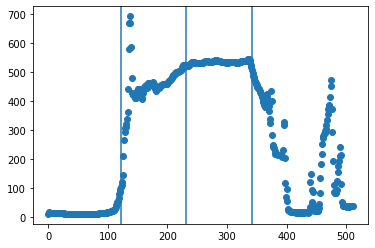

In [88]:
mid = (first + last)//2 # middle of body 

plt.scatter(x, y)
plt.axvline(x=first)
plt.axvline(x=last)
plt.axvline(x=mid)
plt.show()

### TODO: Error when finding slice for end of body because the table also affect variance 

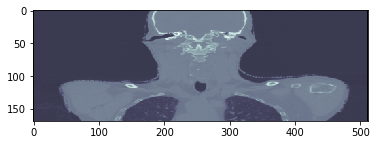

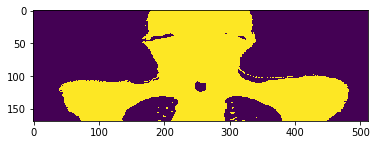

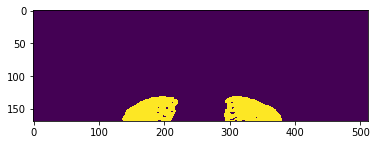

In [89]:
# Choosing which axial slice to use for anlaysis

new_im = forward_im[mid]
plt.imshow(new_im, 'bone')
plt.show()

# Getting mask of image
edit_hist = new_im.ravel()[new_im.ravel()>-2000]
threshold = threshold_otsu(edit_hist)
overlay = (new_im > threshold).astype(int)
plt.imshow(overlay)
plt.show()

labels = measure.label(overlay==1, background = 1)
lung = np.zeros(labels.shape)

# Selecting each object and choosing objects that are touching bottom of the image 
# Assumes that lungs are at the bottom row of the image 
# TODO: Doesn't work for all images (lungs is not at bottom of image), maybe try floodfill to segment lungs

for label in measure.regionprops(labels):
    if (labels == label.label)[0,0] == True:
        pass
    elif (labels == label.label)[0, labels.shape[1]-1] == True:
        pass
    else:
        for coord in label.coords:
            if coord[0] == labels.shape[0]-1:
                lung += (labels == label.label).astype(int)
                break

plt.imshow(lung)
plt.show()

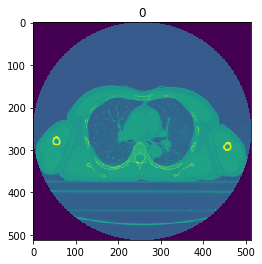

In [90]:
header = nrrd.read_header(image_path)
spacing = dict(header)['space directions']
z_space = spacing[2,2]

top_point = float('inf')
coords = np.where(lung == 1)

#Gets the top point of lungs and uses 10cm below the top point of lung for analysis
for y_val in coords[0]:
    if y_val < top_point:
        top_point = y_val

top_point += int(80//z_space) 
ROI = max(im.shape[0]-top_point, 0)

plt.imshow(im[ROI])
plt.title(ROI)
plt.show()

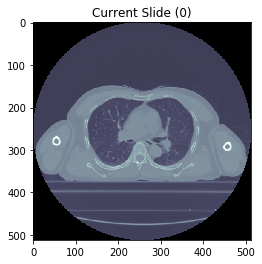

In [91]:
slide = ROI
im_slide = im[slide]
im_slide = cv2.GaussianBlur(im_slide, (1,1), 0)


plt.imshow(im_slide, cmap='bone')
plt.title(f"Current Slide ({slide})")
plt.show()

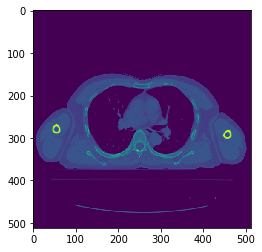

In [92]:
# Remove the background circle (pixels less than -2000 are removed)

image = np.copy(im_slide)
hist_edit = image.ravel()[image.ravel()>-2000]
hist_edit = hist_noise_remove(hist_edit, 20)

a = threshold_otsu(hist_edit)

mask = image>a
image[mask == 0] = a

plt.imshow(image)
plt.show()

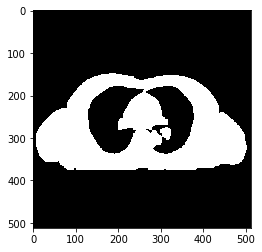

In [93]:
overlay = image>np.amin(image)

overlay8 = np.uint8(overlay)
kernel = np.ones((7,7),np.uint8)

# Use morphology open to prevent non-homogeneity from CT scans 
overlay_morph = cv2.morphologyEx(overlay8, cv2.MORPH_OPEN, kernel)
overlay_morph = (morphology.remove_small_objects(overlay_morph.astype(bool), min_size=1000, connectivity=1)).astype(int)

plt.imshow(overlay_morph, cmap='gray')
plt.show()


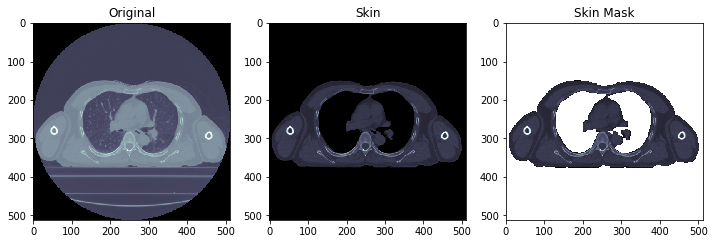

In [94]:
skin = np.copy(im_slide)

skin[overlay_morph == 0] = np.amin(image)

skin_mask = np.ma.masked_where(skin == np.amin(image), skin)

fig, axs = plt.subplots (1,3, figsize=(12,4))  
axs[0].imshow(im_slide, cmap='bone') 
axs[0].set_title(f'Original')
axs[1].imshow(skin,cmap="bone")
axs[1].set_title(f'Skin')
axs[2].imshow(skin_mask,cmap="bone")
axs[2].set_title(f'Skin Mask')
plt.show()


# Lung

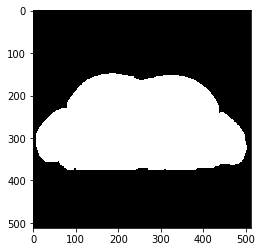

In [95]:
# Get lung segment by floodfilling the chest and subtracting the original image 

overlay_floodfill = overlay_morph.copy()

h, w = overlay_floodfill.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)

# Floodfill from point (0, 0)
cv2.floodFill(overlay_floodfill, mask, (0,0), 255);

overlay_floodfill = (overlay_floodfill < 255).astype(int)
overlay_floodfill = (morphology.remove_small_objects(overlay_floodfill.astype(bool), min_size=1000, connectivity=1)).astype(int)

plt.imshow(overlay_floodfill, cmap='gray')
plt.show()

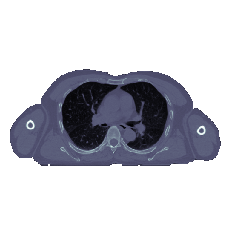

In [96]:
ROI = np.copy(im_slide)
ROI[overlay_floodfill==0] = np.amin(ROI)
ROI_m = np.ma.masked_where(ROI == np.amin(ROI), ROI)

plt.imshow(ROI_m, cmap='bone')
plt.axis('off')
plt.show()

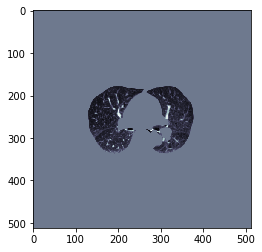

In [97]:
lung_mask = ((overlay_morph-overlay_floodfill)== -1).astype(int)

lung = np.copy(im_slide)
lung[lung_mask == 0]= np.amin(image)


plt.imshow(lung, cmap='bone')
plt.show()

# Organ

In [98]:
# Continually performing morphology closing on lung mask with kernals of different sizes until organ is segmented
# Organ is segmented when there are two objects (the organ and the background)

# TODO: doesn't always work and misses some region of the organs

i = 1
num = 0

lung_m = np.uint8(lung_mask)

while i<100 and num != 2:
    kernel = np.ones((i,i),np.uint8) # change kernal size each iteration

    closing = cv2.morphologyEx(lung_m, cv2.MORPH_CLOSE, kernel)
    labels, num = measure.label(closing, background = 1, return_num = True)
    if num == 2: # check if there is two distinct object 
        area = measure.regionprops(labels)[1]['area']
        if area<500:
            num = 1
    i += 1


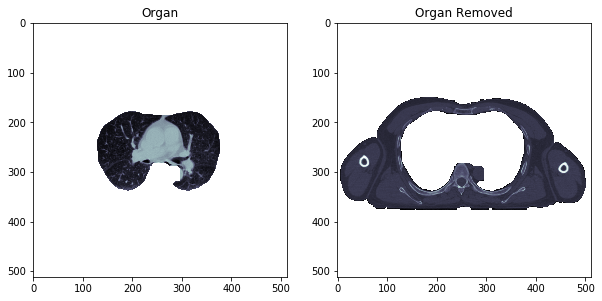

In [99]:
organ_floodfill = closing.copy()

h, w = organ_floodfill.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)

# Floodfill from point (0, 0)
cv2.floodFill(organ_floodfill, mask, (0,0), 255);
organ_floodfill_mask = organ_floodfill<255

organ = np.copy(im_slide)
organ[organ_floodfill_mask == 0] = np.amin(organ)-1
organ_mask = np.ma.masked_where(organ == np.amin(organ), organ)

organ_remove = np.copy(skin)
organ_remove[organ_floodfill_mask == 1] = np.amin(image)
organ_remove_mask = np.ma.masked_where(organ_remove == np.amin(organ_remove), organ_remove)

fig, axs = plt.subplots (1,2, figsize=(10,10))  
axs[0].imshow(organ_mask, cmap='bone') 
axs[0].set_title(f"Organ")
axs[1].imshow(organ_remove_mask, cmap="bone")
axs[1].set_title(f"Organ Removed")
plt.show()


# Bone

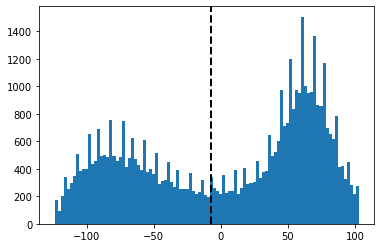

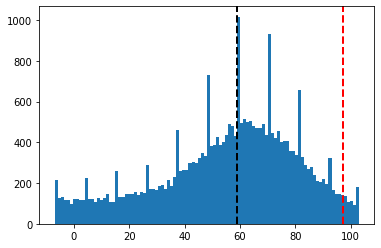

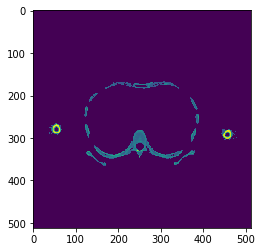

97.19922542572021


In [100]:
skin_hist = organ_remove.ravel()[organ_remove.ravel() != np.amin(organ_remove.ravel())]
skin_hist_edit = np.around(skin_hist, 1)
skin_hist_edit = hist_noise_remove(skin_hist_edit, 80)
skin_hist_edit = skin_hist_edit[skin_hist_edit < 1500]
t = threshold_otsu(skin_hist_edit)


plt.hist(skin_hist_edit.ravel(), bins=100)
plt.axvline(t, color='k', linestyle='dashed', linewidth=2)
plt.show()

a = skin_hist_edit.ravel()[skin_hist_edit.ravel() > t]
median = np.median(a)
std = np.std(a)
thres = median + 1.5*std

plt.hist(a.ravel(), bins=100)
plt.axvline(median, color='k', linestyle='dashed', linewidth=2)
plt.axvline(thres, color='r', linestyle='dashed', linewidth=2)
plt.show()

bone = np.copy(organ_remove)
bone_mask = (organ_remove>thres)
bone_mask = (morphology.remove_small_objects(bone_mask,min_size=100, connectivity=2)).astype(int)
bone[bone_mask == 0] = np.amin(bone)

plt.imshow(bone)
plt.show()
print(thres)

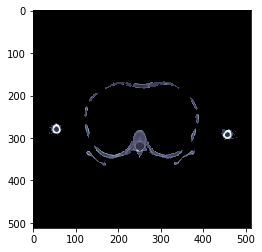

In [101]:
# Floodfills bones to include middle of bone

bone_seg = bone

bone_floodfill = bone_seg.copy()

h, w = bone_floodfill.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)

# Floodfill from point (0, 0)
cv2.floodFill(bone_floodfill, mask, (0,0), 255);
bone_floodfill_mask = bone_floodfill<255

bone_ff = np.copy(organ_remove)
bone_mask = ((bone_floodfill_mask + (bone>np.amin(bone))) > 0).astype(int)
bone_ff[bone_mask == 0] = np.amin(bone_ff)

plt.imshow(bone_ff, cmap='bone')
plt.show()


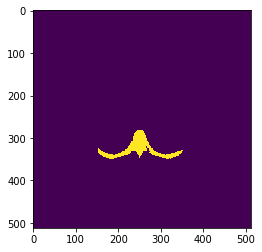

In [102]:
# Obtain spine based on largest object in middle 
# Doesn't always work when spine is off center

spine = np.ones(bone_ff.shape)
y = int(bone_ff.shape[0]*0.3)
x = int(bone_ff.shape[1]*0.3)

spine = spine*np.amin(bone_ff)
spine[y:bone_ff.shape[0]-y, x:bone_ff.shape[1]-x] = bone_ff[y:bone_ff.shape[0]-y, x:bone_ff.shape[1]-x]

spine_label = measure.label(spine>np.amin(spine))

# Choosing largest object
items = regionprops(spine_label)
largest = items[0]
for i in items:
    if i['area'] > largest['area']:
        largest = i

spine = spine_label==largest['label']
        
plt.imshow(spine)
plt.show()

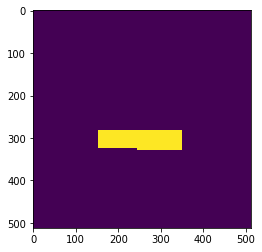

In [103]:
coord = np.where(spine)
highest_point = np.amin(coord[0])
for i in range(len(coord[0])):
    if coord[0][i] == highest_point:
        break

highest_point = coord[0][i], coord[1][i]

right_point = np.amax(coord[1])
for i in range(len(coord[0])):
    if coord[1][i] == right_point:
        break

right_point = coord[0][i], coord[1][i]

left_point = np.amin(coord[1])
for i in range(len(coord[0])):
    if coord[1][i] == left_point:
        break
left_point = coord[0][i], coord[1][i]



region_delete = np.zeros(spine.shape)
region_delete[highest_point[0]:right_point[0], highest_point[1]:right_point[1]] = 1
region_delete[highest_point[0]:left_point[0], left_point[1]:highest_point[1]] = 1


plt.imshow(region_delete)
plt.show()

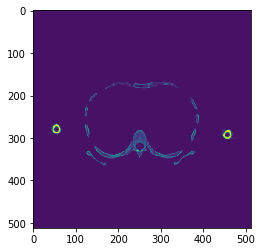

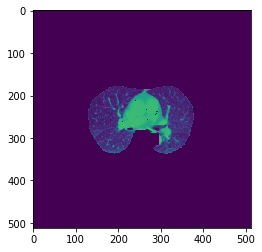

In [104]:
# Attempt to removing regions of organ that was segmented 
# as part of bone and adding it back to organ

bone_label = (bone_ff > np.amin(bone_ff)).astype(int) - spine
bone_label = measure.label(bone_label)

remove_obj = []

items = regionprops(bone_label)
for item in items:
    id_ = item['label']
    obj = (bone_label == id_).astype(int)
    if 2 in np.unique(obj+region_delete):
        remove_obj.append(obj)

bone_mask = (bone_ff > np.amin(bone_ff)).astype(int)
organ_mask = (organ > np.amin(organ)).astype(int)
for item in remove_obj:
    bone_mask -= item
    organ_mask += item
    
plt.imshow(bone_mask*bone_ff)
plt.show()

organ = ROI*organ_mask
organ[organ == organ[0,0]] = np.amin(organ) - 1
plt.imshow(organ)
plt.show()


# Muscle segmentation

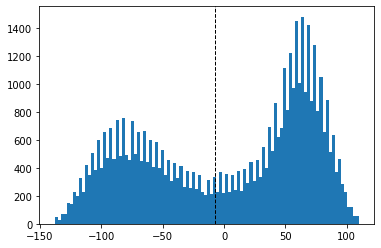

In [105]:
# Sepperate muscle and fat using OTSU thresholdng

mask = (organ_remove>np.amin(organ_remove)).astype(int) - (bone>np.amin(bone)).astype(int)
muscle_fat = np.copy(organ_remove)
muscle_fat[mask == 0] = np.amin(muscle_fat)

muscle_fat_h = muscle_fat.ravel()[muscle_fat.ravel() != np.amin(muscle_fat.ravel())]
muscle_fat_edit = np.around(muscle_fat_h, 1)
muscle_fat_edit = hist_noise_remove(muscle_fat_edit, 20)

t = threshold_otsu(muscle_fat_edit)

plt.hist(muscle_fat_edit, bins = 100)
plt.axvline(t, color='k', linestyle='dashed', linewidth=1)
plt.show()


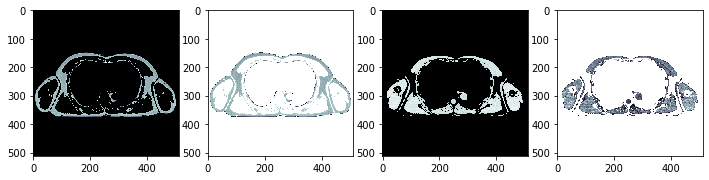

Revised Threshold=-9.0
	Mean FAT Intensity=-77.0 pixels
	Mean MUSCLE Intensity=59.0 pixels




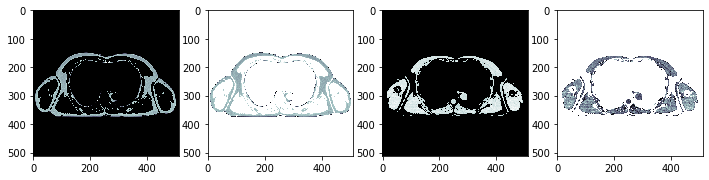

Revised Threshold=-9.0
	Mean FAT Intensity=-77.0 pixels
	Mean MUSCLE Intensity=59.0 pixels




In [106]:
# Use ITSA to optimize threshold for sepperating fat and muscle

thres = t

print_image = True
k = 0
ThPrev=np.inf #previous
ThRev=thres

image = muscle_fat

#apply threshold
while ThRev!=ThPrev: #while new threshold is NOT equal to prev threshold

    ThPrev=ThRev #update the previous threshold for comparison in subsequent iterations

    premusclemask = (image>ThRev)
    musclemask = (morphology.remove_small_objects(premusclemask,min_size=8, connectivity=2))

    #Get Bone and Tissue segment
    muscleseg = np.copy(image)
    muscleseg[musclemask==0] = np.amin(image)

    fatseg = np.copy(image)
    fatseg[musclemask==1] = np.amin(image)

    #masking the 0's in the image to exclude in the mean calculations
    fat_seg_mask=np.ma.masked_where(fatseg == np.amin(fatseg), fatseg)
    muscle_seg_mask=np.ma.masked_where(muscleseg==np.amin(muscleseg),muscleseg)
    
    #Calculate median signal intensities
    fat_mean=np.median(fatseg[fatseg!=np.amin(fatseg)])
    muscle_mean=np.median(muscleseg[muscleseg!=np.amin(muscleseg)])

    #Threshold optimization equation
    ThRev = (muscle_mean+fat_mean)/2
    
    if print_image:
        fig, axs = plt.subplots (1,4, figsize=(12,4))  
        axs[0].imshow(fatseg, cmap='bone') 
        axs[1].imshow(fat_seg_mask,cmap="bone")
        axs[2].imshow(muscleseg,cmap="bone")
        axs[3].imshow(muscle_seg_mask,cmap="bone") 
        plt.show()

        print(f"Revised Threshold={ThRev}\n\tMean FAT Intensity={fat_mean} pixels\n\tMean MUSCLE Intensity={muscle_mean} pixels\n\n")
    k+=1
    if k==50:
        print('Unable to find optimal threshold')
        break


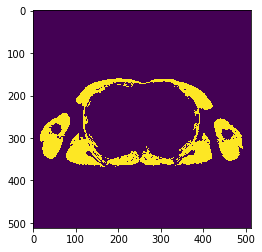

In [107]:
muscle_o = (muscleseg > np.amin(muscleseg))
muscle_m = np.uint8(((morphology.remove_small_objects(muscle_o,min_size=1000, connectivity=2))))

plt.imshow(muscle_m)
plt.show()


# Fat

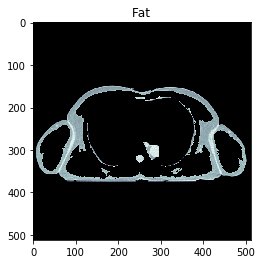

In [108]:
fat = np.copy(muscle_fat)
fat[muscle_m == 1] = np.amin(fat)
fat_edit = morphology.remove_small_objects((fat>np.amin(fat)),min_size=100, connectivity=1)
fat[fat_edit == 0] = np.amin(fat)

plt.imshow(fat, cmap='bone')
plt.title('Fat')
plt.show()


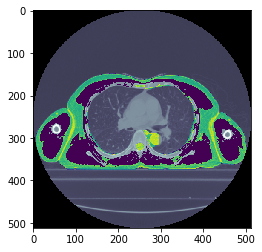

In [109]:
plt.imshow(im_slide, cmap='bone')
f = np.ma.masked_where(fat == np.amin(fat), fat)
m = np.ma.masked_where(muscle_m == np.amin(muscle_m), muscle_m)
plt.imshow(f)
plt.imshow(m)


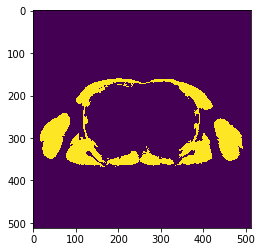

In [110]:
muscle_floodfill = muscle_m.copy()

h, w = muscle_floodfill.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)

# Floodfill from point (0, 0)
cv2.floodFill(muscle_floodfill, mask, (0,0), 255);

muscle_floodfill = (muscle_floodfill < 255).astype(int)
muscle_floodfill = (morphology.remove_small_objects(muscle_floodfill.astype(bool), min_size=1000, connectivity=1)).astype(int)
muscle_floodfill = ((muscle_floodfill - (fat > np.amin(fat)))==1).astype(int)
plt.imshow(muscle_floodfill)
plt.show()

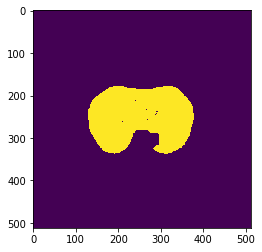

In [111]:
organ_c = organ.copy()
organ_c[organ_c == organ_c[0,0]] = np.amin(organ_c)-1
plt.imshow(organ_c>np.amin(organ_c))

muscle_floodfill = ((muscle_floodfill - (bone>np.amin(bone))) == 1).astype(int)
muscle_floodfill = muscle_floodfill - (organ_c>np.amin(organ_c)) > 0

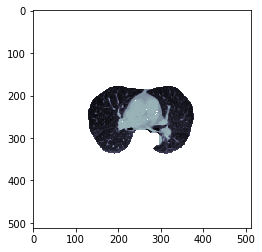

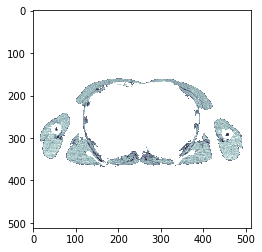

In [112]:
muscle_floodfill_s = (morphology.remove_small_objects(muscle_floodfill.astype(bool), min_size=3000, connectivity=1)).astype(int)
muscle_noise = muscle_floodfill-muscle_floodfill_s
muscle_noise_label = measure.label(muscle_noise)

remove_obj = []

items = regionprops(muscle_noise_label)
for item in items:
    id_ = item['label']
    obj = (muscle_noise_label == id_).astype(int)
    if 2 in np.unique(obj+region_delete):
        remove_obj.append(obj)

muscle_floodfill = muscle_floodfill.astype(int)
organ_mask = (organ > np.amin(organ)).astype(int)
for item in remove_obj:
    muscle_floodfill -= item
    organ_mask += item

organ = organ_mask*ROI
organ[organ == organ[0,0]] = np.amin(organ) - 1
muscle_floodfill 

muscle_new = muscle_floodfill*skin
muscle_new[muscle_new == muscle_new[0,0]] = np.amin(muscle_new)-1

plt.imshow(np.ma.masked_where(organ == organ[0,0], organ), cmap='bone')
plt.show()
plt.imshow(np.ma.masked_where(muscle_new == muscle_new[0,0], muscle_new), cmap='bone')
plt.show()

# TEST ARM MUSCLE 

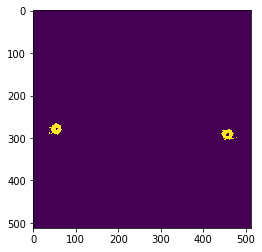

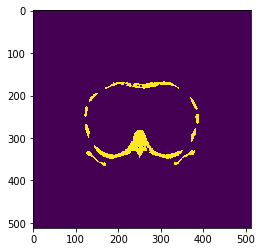

In [113]:
# Segment arm muscle by finding bone object in the right fifth and left fifth of the image  

bone_m = (bone_mask*bone_ff) > (bone_mask*bone_ff)[0,0]

arm = bone_m.copy()
fifth = int((1/5) * bone_m.shape[0])

arm[:, fifth:arm.shape[1]-fifth] = np.amin(bone_m)
arm = (morphology.remove_small_objects(arm.astype(bool), min_size=20, connectivity=1)).astype(int)
plt.imshow(arm)
plt.show()

chest = bone_m.copy()
chest[:, 0:fifth] = np.amin(bone_m)
chest[:, arm.shape[1]-fifth:] = np.amin(bone_m)
chest = (morphology.remove_small_objects(chest.astype(bool), min_size=20, connectivity=1)).astype(int)

plt.imshow(chest)
plt.show()

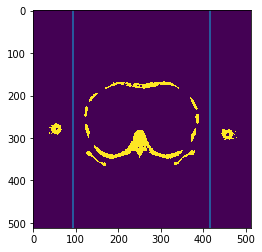

In [114]:
_, x_chest = np.where(chest == 1)

arm_l = arm.copy()
arm_l[:, arm_l.shape[1]//2:] = 0
_, arm_lx = np.where(arm_l == 1)

arm_r = arm.copy()
arm_r[:, :arm_r.shape[1]//2] = 0
_, arm_rx = np.where(arm_r == 1)

mid_left = (min(x_chest) + max(arm_lx))//2
mid_right = (max(x_chest) + min(arm_rx))//2

plt.imshow(bone_m) 
plt.axvline(x=mid_left)
plt.axvline(x=mid_right)
plt.show()

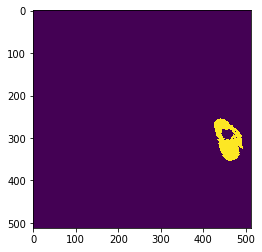

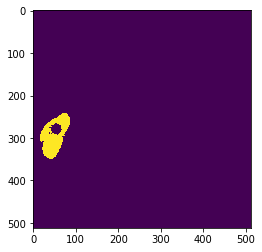

In [115]:
# Sepperate arm muscle 

muscle_label = muscle_new > np.amin(muscle_new)
muscle_label = measure.label(muscle_label)

left_arm = np.zeros(muscle_label.shape)
right_arm = np.zeros(muscle_label.shape)

# Try to sepperate based on objects (only works when arm muscle is sepperated from other muscles)
for label in measure.regionprops(muscle_label):
    if label.area < 100:
        continue
    left_most = min(label.coords[: , 1])
    right_most = max(label.coords[: , 1])
    if mid_left > left_most:
        right = label.coords[: , 1][label.coords[: , 1] > mid_left]
        if len(right) < 1000:
            left_arm += muscle_label == label.label
    elif mid_right < right_most:
        left = label.coords[: , 1][label.coords[: , 1] < mid_right]
        if len(left) < 1000:
            right_arm += muscle_label == label.label

# Checks if arm muscle is sepperated from other muscles
# if not, sepperate arm muscles based on threshold
if len(np.where(left_arm)[0]) < 2500:
    left_arm = (muscle_new > np.amin(muscle_new))
    left_arm[:, mid_left:] = 0
if len(np.where(right_arm)[0]) < 2500:
    right_arm = (muscle_new > np.amin(muscle_new))
    right_arm[:, :mid_right] = 0

plt.imshow(right_arm)
plt.show()
plt.imshow(left_arm)
plt.show()

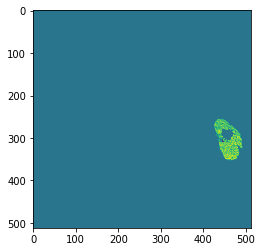

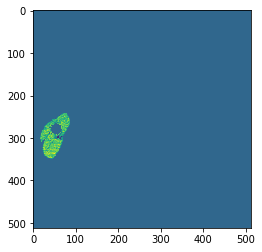

In [116]:
right_arm_im = right_arm * im_slide
left_arm_im = left_arm * im_slide
plt.imshow(right_arm_im)
plt.show()
plt.imshow(left_arm_im)
plt.show()

# TEST CHEST MUSCLE 

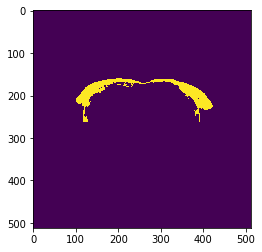

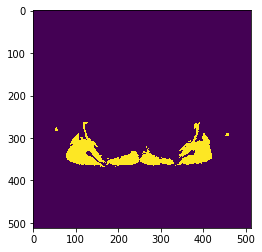

In [117]:
# Sepperate pectoral and back muscle by finding midpoint to sepperate muscles

chest = (muscle_new > np.amin(muscle_new)).astype(int)
chest -= (right_arm).astype(int)
chest -= (left_arm).astype(int)

y, x = np.where(chest == 1)
mid = (max(y) + min(y)) // 2

upper_chest = chest.copy()
upper_chest[mid:, :] = 0
lower_chest = chest.copy()
lower_chest[:mid, :] = 0  
    
plt.imshow(upper_chest)
plt.show()
plt.imshow(lower_chest)
plt.show()  

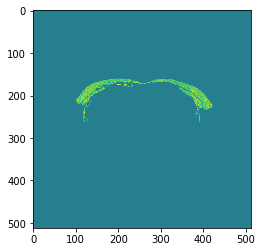

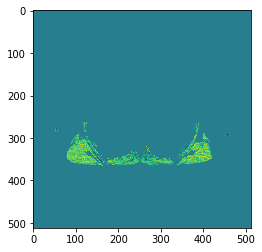

In [118]:
upper_im = upper_chest * im_slide
lower_im = lower_chest * im_slide
plt.imshow(upper_im)
plt.show()
plt.imshow(lower_im)
plt.show()

# Volume of segments

In [119]:
# Get number of pixel of different regions
fat_num = np.count_nonzero((fat!=fat[0,0]).astype(int))
muscle_num = np.count_nonzero((muscle_new!=muscle_new[0,0]).astype(int))
right_arm_num = np.count_nonzero(right_arm)
left_arm_num = np.count_nonzero(left_arm)
upper_chest_num = np.count_nonzero(upper_chest)
lower_chest_num = np.count_nonzero(lower_chest)
bone_num = np.count_nonzero(bone_m)


print(f'Number of fat pixels: {fat_num} pixels')
print(f'Number of muscle pixels: {muscle_num} pixels')
print(f'Number of right arm pixels: {right_arm_num} pixels')
print(f'Number of left arm pixels: {left_arm_num} pixels')
print(f'Number of pectoralis pixels: {upper_chest_num} pixels')
print(f'Number of back pixels: {lower_chest_num} pixels')
print(f'Number of bone pixels: {bone_num} pixels')

Number of fat pixels: 24612 pixels
Number of muscle pixels: 25584 pixels
Number of right arm pixels: 3894 pixels
Number of left arm pixels: 4098 pixels
Number of pectoralis pixels: 6311 pixels
Number of back pixels: 11281 pixels
Number of bone pixels: 7579 pixels


In [120]:
# Get pixel spacing based on header metadata
header = nrrd.read_header(image_path)
spaceing = dict(header)['space directions']

x_space, y_space, z_space = spaceing[0,0], spaceing[1,1], spaceing[2,2]
pixel_volume = x_space * y_space * z_space # mm3

In [121]:
# Get volume of different regions
fat_vol = round(fat_num * pixel_volume, 2)
muscle_vol = round(muscle_num * pixel_volume, 2) 
right_arm_vol = round(right_arm_num * pixel_volume, 2)  
left_arm_vol = round(left_arm_num * pixel_volume, 2)  
upper_chest_vol = round(upper_chest_num * pixel_volume, 2)  
lower_chest_vol = round(lower_chest_num * pixel_volume, 2)  
bone_vol = round(bone_num * pixel_volume, 2)  

print(f'Total Muscle volume: {muscle_vol} mm3')
print(f'Total Fat volume: {fat_vol} mm3')
print(f'Total right arm volume: {right_arm_vol} mm3')
print(f'Total left arm volume: {left_arm_vol} mm3')
print(f'Total pectoralis volume: {upper_chest_vol} mm3')
print(f'Total back volume: {lower_chest_vol} mm3')
print(f'Total bone volume: {bone_vol} mm3')

Total Muscle volume: 43214.5 mm3
Total Fat volume: 41572.67 mm3
Total right arm volume: 6577.44 mm3
Total left arm volume: 6922.02 mm3
Total pectoralis volume: 10660.05 mm3
Total back volume: 19054.99 mm3
Total bone volume: 12801.86 mm3


# Muscle Mass

In [122]:
# Based on database (http://sbcrowe.net/ct-density-tables/)
mass_density = [0.000, 0.290 ,0.450, 0.943, 0.985, 1.016, 1.0, 1.052, 1.089, 1.145, 1.159, 1.335, 1.560, 1.823] #g/cc
GE_LightSpeed_HU = [-991.5, -729.2, -541.8, -92.8, -33.0, 3.7, -2.9 ,28.7, 64.9, 212.7, 227.4, 442.0, 791.2, 1191.8]
Siemens_HU = [-969.8, -712.9, -536.5, -95.6, -45.6, -1.9, -5.6, 25.7, 65.6, 207.5, 220.7, 429.9, 775.3, 1173.7]
Toshiba_HU = [-970.3, -720.8, -543.3, -67.2, -36.4, -5.5, -5.1, 16.8, 65.8, 211.0, 229.6, 464.4, 831.1, 1256.2]


def GE_LightSpeed(x):
  slope, intercept, r, p, std_err = stats.linregress(mass_density, GE_LightSpeed_HU)  
  return (x - intercept)/slope

def Siemens(x):
  slope, intercept, r, p, std_err = stats.linregress(mass_density, Siemens_HU)  
  return (x - intercept)/slope

def Toshiba(x):
  slope, intercept, r, p, std_err = stats.linregress(mass_density, Toshiba_HU)  
  return (x - intercept)/slope

In [123]:
# Get total mass of different regions
muscle_mask = np.ma.masked_where(muscle_new == muscle_new[0,0], muscle_new)
fat_mask = np.ma.masked_where(fat == fat[0,0], fat)
right_mask = np.ma.masked_where(right_arm_im == right_arm_im[0,0], right_arm_im)
left_mask = np.ma.masked_where(left_arm_im == left_arm_im[0,0], left_arm_im)
upper_mask = np.ma.masked_where(upper_im == upper_im[0,0], upper_im)
lower_mask = np.ma.masked_where(lower_im == lower_im[0,0], lower_im)
bone_mask = np.ma.masked_where(bone_ff == bone_ff[0,0], bone_ff)


voxel_volume = pixel_volume/1000 #cm3

voxel_mass_m = []
voxel_mass_f = []
voxel_mass_right_arm = []
voxel_mass_left_arm = []
voxel_mass_pect = []
voxel_mass_back = []
voxel_mass_bone = []


for i in range(muscle_mask.shape[0]):
    for j in range(muscle_mask.shape[1]):
        if not isinstance(muscle_mask[i,j], np.ma.core.MaskedConstant):
            voxel_density = GE_LightSpeed(muscle_mask[i,j])
            voxel_mass_m.append(voxel_volume * voxel_density)
        if not isinstance(fat_mask[i,j], np.ma.core.MaskedConstant):
            voxel_density = GE_LightSpeed(fat_mask[i,j])
            voxel_mass_f.append(voxel_volume * voxel_density)
        if not isinstance(right_mask[i,j], np.ma.core.MaskedConstant):
            voxel_density = GE_LightSpeed(right_mask[i,j])
            voxel_mass_right_arm.append(voxel_volume * voxel_density)
        if not isinstance(left_mask[i,j], np.ma.core.MaskedConstant):
            voxel_density = GE_LightSpeed(left_mask[i,j])
            voxel_mass_left_arm.append(voxel_volume * voxel_density)
        if not isinstance(upper_mask[i,j], np.ma.core.MaskedConstant):
            voxel_density = GE_LightSpeed(upper_mask[i,j])
            voxel_mass_pect.append(voxel_volume * voxel_density)
        if not isinstance(lower_mask[i,j], np.ma.core.MaskedConstant):
            voxel_density = GE_LightSpeed(lower_mask[i,j])
            voxel_mass_back.append(voxel_volume * voxel_density)
        if not isinstance(bone_mask[i,j], np.ma.core.MaskedConstant):
            voxel_density = GE_LightSpeed(bone_mask[i,j])
            voxel_mass_bone.append(voxel_volume * voxel_density)
            
total_mass_m = round(sum(voxel_mass_m), 5)
total_mass_f = round(sum(voxel_mass_f), 5)
total_mass_right = round(sum(voxel_mass_right_arm), 5)
total_mass_left = round(sum(voxel_mass_left_arm), 5)
total_mass_upper = round(sum(voxel_mass_pect), 5)
total_mass_lower = round(sum(voxel_mass_back), 5)
total_mass_bone = round(sum(voxel_mass_bone), 5)


print(f'Total Muscle Mass: {total_mass_m} g')
print(f'Total Fat Mass: {total_mass_f} g')
print(f'Total Right Arm Mass: {total_mass_right} g')
print(f'Total Left Arm Mass: {total_mass_left} g')
print(f'Total Pect Mass: {total_mass_upper} g')
print(f'Total Back Mass: {total_mass_lower} g')
print(f'Total Bone Mass: {total_mass_bone} g')

KeyboardInterrupt: 

# Muscle Density

In [ ]:
def density(mass, vol):
    return round(mass/(vol/1000), 4)

In [ ]:
# Get density of different regions
muscle_density = density(total_mass_m, muscle_vol) # in g/cm3
fat_density = density(total_mass_f, fat_vol)

right_density = density(total_mass_right, right_arm_vol)
left_density = density(total_mass_left, left_arm_vol)
upper_density = density(total_mass_upper, upper_chest_vol)
lower_density = density(total_mass_lower, lower_chest_vol)
bone_density = density(total_mass_bone, bone_vol)

print(f'Muscle Density: {muscle_density} g/cm3')
print(f'Fat Density: {fat_density} g/cm3')
print(f'Right Arm Density: {right_density} g/cm3')
print(f'Left Arm Density: {left_density} g/cm3')
print(f'Pect Density: {upper_density} g/cm3')
print(f'Back Density: {lower_density} g/cm3')
print(f'Bone Density: {bone_density} g/cm3')

# Writing Data

In [ ]:
if total_mass_right == 0 or total_mass_left == 0:
    from IPython.display import Javascript
    display(Javascript('IPython.notebook.execute_all_cells()'))

In [ ]:
import csv

if not os.path.exists('data.csv'):
    with open('data.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['File', "MD_All", 'MM_All', 'MV_All', 
                         'FD_All', 'FM_All','FV_All', 
                         'MD_LArm', 'MM_LArm','MV_LArm',
                        'MD_RArm', 'MM_RArm','MV_RArm',
                        'MD_Pec', 'MM_Pec','MV_Pec',
                        'MD_Pspine', 'MM_Pec','MV_Pspine',
                        'BMD_All', 'BMM_All','BMV_All'])
        writer.writerow([name_split[0], muscle_density, total_mass_m, muscle_vol, 
                        fat_density, total_mass_f, fat_vol,
                        left_density, total_mass_left, left_arm_vol,
                        right_density, total_mass_right, right_arm_vol,
                        upper_density, total_mass_upper, upper_chest_vol,
                        lower_density, total_mass_lower, lower_chest_vol,
                        bone_density, total_mass_bone, bone_vol])
        f.close()
else:
    with open('data.csv', 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([name_split[0], muscle_density, total_mass_m, muscle_vol, 
                        fat_density, total_mass_f, fat_vol,
                        left_density, total_mass_left, left_arm_vol,
                        right_density, total_mass_right, right_arm_vol,
                        upper_density, total_mass_upper, upper_chest_vol,
                        lower_density, total_mass_lower, lower_chest_vol,
                        bone_density, total_mass_bone, bone_vol])
        f.close()

In [ ]:
dirname = os.path.join('result', name_split[0])
print(dirname)
try:
    os.makedirs(dirname)
except FileExistsError:
    pass 


nrrd.write(os.path.join(dirname, 'muscle.nrrd'), muscle_new)
nrrd.write(os.path.join(dirname, 'organ.nrrd'), organ)
nrrd.write(os.path.join(dirname, 'fat.nrrd'), fat)
nrrd.write(os.path.join(dirname, 'bone.nrrd'), bone)
nrrd.write(os.path.join(dirname, 'original.nrrd'), ROI)
nrrd.write(os.path.join(dirname, 'left_arm.nrrd'), left_arm_im)
nrrd.write(os.path.join(dirname, 'right_arm.nrrd'), right_arm_im)
nrrd.write(os.path.join(dirname, 'pect_chest.nrrd'), upper_im)
nrrd.write(os.path.join(dirname, 'back_chest.nrrd'), lower_im)

In [ ]:
def append_df_to_excel(filename, df, sheet_name='Sheet1', startrow=None,
                       truncate_sheet=False, 
                       **to_excel_kwargs):
    """
    Append a DataFrame [df] to existing Excel file [filename]
    into [sheet_name] Sheet.
    If [filename] doesn't exist, then this function will create it.

    @param filename: File path or existing ExcelWriter
                     (Example: '/path/to/file.xlsx')
    @param df: DataFrame to save to workbook
    @param sheet_name: Name of sheet which will contain DataFrame.
                       (default: 'Sheet1')
    @param startrow: upper left cell row to dump data frame.
                     Per default (startrow=None) calculate the last row
                     in the existing DF and write to the next row...
    @param truncate_sheet: truncate (remove and recreate) [sheet_name]
                           before writing DataFrame to Excel file
    @param to_excel_kwargs: arguments which will be passed to `DataFrame.to_excel()`
                            [can be a dictionary]
    @return: None

    Usage examples:

    >>> append_df_to_excel('d:/temp/test.xlsx', df)

    >>> append_df_to_excel('d:/temp/test.xlsx', df, header=None, index=False)

    >>> append_df_to_excel('d:/temp/test.xlsx', df, sheet_name='Sheet2',
                           index=False)

    >>> append_df_to_excel('d:/temp/test.xlsx', df, sheet_name='Sheet2', 
                           index=False, startrow=25)

    (c) [MaxU](https://stackoverflow.com/users/5741205/maxu?tab=profile)
    """
    # Excel file doesn't exist - saving and exiting
    if not os.path.isfile(filename):
        df.to_excel(
            filename,
            sheet_name=sheet_name, 
            startrow=startrow if startrow is not None else 0, 
            **to_excel_kwargs)
        return
    
    # ignore [engine] parameter if it was passed
    if 'engine' in to_excel_kwargs:
        to_excel_kwargs.pop('engine')

    writer = pd.ExcelWriter(filename, engine='openpyxl', mode='a')

    # try to open an existing workbook
    writer.book = load_workbook(filename)
    
    # get the last row in the existing Excel sheet
    # if it was not specified explicitly
    if startrow is None and sheet_name in writer.book.sheetnames:
        startrow = writer.book[sheet_name].max_row

    # truncate sheet
    if truncate_sheet and sheet_name in writer.book.sheetnames:
        # index of [sheet_name] sheet
        idx = writer.book.sheetnames.index(sheet_name)
        # remove [sheet_name]
        writer.book.remove(writer.book.worksheets[idx])
        # create an empty sheet [sheet_name] using old index
        writer.book.create_sheet(sheet_name, idx)
    
    # copy existing sheets
    writer.sheets = {ws.title:ws for ws in writer.book.worksheets}

    if startrow is None:
        startrow = 0

    # write out the new sheet
    df.to_excel(writer, sheet_name, startrow=startrow, **to_excel_kwargs)

    # save the workbook
    writer.save()

In [ ]:
from IPython.display import Javascript
display(Javascript('IPython.notebook.execute_all_cells()'))